In [1]:
import numpy as np
from math import *
import matplotlib.pyplot as plt
from scipy.stats import t
from bisect import bisect
import scipy.io
import copy
from scipy.stats import norm
from scipy.special import gamma
import numpy.matlib
%matplotlib inline
import h5py

Cutting the MH budget method refers to Korattikara's 2014 paper

Adaptive MH method refers to Bardenet's 2014 paper

In [2]:
# generate some ground truth
N = 1000000;
sigma1_sq = 10
sigma2_sq = 1
sigmax_sq = 2
theta1 = 0
theta2 = 1

# Generate the data matrix. Note that the np.random.normal(...) requires STD (not VAR).
X = np.zeros(N)
for i in xrange(N):
    u = np.random.random()
    if (u < 0.5):
        X[i] = np.random.normal(theta1, np.sqrt(sigmax_sq))
    else:
        X[i] = np.random.normal(theta1+theta2, np.sqrt(sigmax_sq))


def log_f(theta, X, N, T):
    # the variance of X is 2, the variance of theta[0] is 10, the variance of theta[1] is 1
    scale_and_temp = N / float(len(X) * T)
    
    inverse_covariance = np.array([[0.1,0],[0,1]])
    prior_constant = 1.0 / (2*np.pi*np.sqrt(10))
    prior = np.log(prior_constant) - 0.5*(theta.T).dot(inverse_covariance).dot(theta)
    
    X_all = X.reshape((len(X),1))
    ll_constant = (1.0 / (4*np.sqrt(np.pi)))
    L = ll_constant * (np.exp(-0.25*(X_all-theta[0])**2) + np.exp(-0.25*(X_all-(theta[0]+theta[1]))**2))
    log_likelihood = np.sum(np.log(L)) * scale_and_temp
    
    assert (N / float(len(X))) >= 1
    assert not np.isnan(prior + log_likelihood)
    return (prior + log_likelihood)[0,0]


def estimate_kl_divergence(all_thetas, d_space, full_data, temp=10000, contour=False):
   
    (m,n) = all_thetas.shape
    assert m == 2
    assert 0.001 <= d_space <= 1.0 
    
    # Let's deal with the grid limits and perform any necessary clipping of data.
    (min_x, max_x) = (-1.5, 2.5)
    (min_y, max_y) = (-2.5, 3.0)
    clipped_thetas = np.zeros((m,n))
    clipped_thetas[0] = np.maximum( np.minimum(all_thetas[0], max_x), min_x )
    clipped_thetas[1] = np.maximum( np.minimum(all_thetas[1], max_y), min_y )
    
    # Round each element in clipped_thetas to its nearest multiple within d_space.
    thetas_rounded = d_space * np.rint(clipped_thetas/d_space)
    
    # Form the grid of points. Add d_space because arange doesn't include the last element.
    x_coords = np.arange(min_x, max_x + d_space, d_space)
    y_coords = np.arange(min_y, max_y + d_space, d_space)
    num_x = len(x_coords)
    num_y = len(y_coords)
    
    # Deal with the source distribution (theoretical distribution), which calls our function. Exponentiate later.
    source_distribution = np.zeros((num_x,num_y))
    for xc in range(num_x):
        for yc in range(num_y):
            (theta1,theta2) = (x_coords[xc],y_coords[yc])
            this_theta = np.array([[theta1],[theta2]])
            source_distribution[xc,yc] = log_f(this_theta, full_data, len(full_data), temp)
            assert not np.isnan(source_distribution[xc,yc])
    source_distribution = np.exp(source_distribution)
    
    # Do the target distribution (actual data), iterating through theta_rounded. Do NOT exponentiate!
    target_distribution = np.zeros((num_x,num_y))
    for theta in thetas_rounded.T: 
        # Note the transpose above. Given theta, multiply by d_space to get integer coords.
        (xt,yt) = np.rint(theta/d_space)
        xt = int(xt)
        yt = int(yt)
        target_distribution[xt,yt] = target_distribution[xt,yt] + 1
    
    # Smooth the distributions by adding in a small constant, then normalize.
    # eps = 0.0001
    # source_distribution = source_distribution + eps
    # target_distribution = target_distribution + eps
    source_distribution = source_distribution / np.sum(source_distribution)
    target_distribution = target_distribution / np.sum(target_distribution)
    
    source_distribution = np.rint(source_distribution * n)
    target_distribution = np.rint(target_distribution * n)
    # Finally, compute an estimate of the KL divergence.
    kldiv = 0.0
    for xc in range(num_x):
        for yc in range(num_y):
            p_xy = source_distribution[xc,yc]
            q_xy = target_distribution[xc,yc]
            if p_xy != 0.0 and q_xy!=0.0:
                # kldiv += (p_xy)*(np.log(p_xy) - np.log(q_xy))
                kldiv += q_xy * np.log(p_xy) *1.0 - p_xy *1.0 - np.log(gamma(q_xy+1))
                assert not np.isnan(kldiv)
        
    # Return what we want all along.
    return kldiv

In [3]:
# test parameters : with nsamps = 5000, minibatchsize = 100, sigma_proposer = 0.3
# number of data points = 1000,000 temperature = 10,000
'''load data '''
f = h5py.File('gaussiandata.mat','r');
samples1 = np.array(f['newtestsamples'])
samples2 = np.array(f['oldtestsamples'])
samples3 = np.array(f['cutmhsamples'])
samples4 = np.array(f['adaptivemhsamples'])
samples5 = np.array(f['cutmhwithsamples'])
size1 = np.array(f['newtestsize'])
size2 = np.array(f['oldtestsize'])
size3 = np.array(f['cutmhsize'])
size4 = np.array(f['adaptivemhsize'])
size5 = np.array(f['cutmhwithsize'])
ll1 = np.array(f['newtestll'])
ll2 = np.array(f['oldtestll'])
ll3 = np.array(f['cutmhll'])
ll4 = np.array(f['adaptivemhll'])
bc1c2 = np.array(f['adaptivemhbc1c2'])
time_list = np.array(f['time_list'])
print 'load data finished!'

load data finished!


In [4]:
# calculate kl divergence
kl1 = estimate_kl_divergence(samples1.T, 0.1, X, 10000.0)
print kl1
kl2 = estimate_kl_divergence(samples2.T, 0.1, X, 10000.0)
print kl2
kl3 = estimate_kl_divergence(samples3.T, 0.1, X, 10000.0)
print kl3
kl4 = estimate_kl_divergence(samples4.T, 0.1, X, 10000.0)
print kl4
kl5 = estimate_kl_divergence(samples5.T, 0.1, X, 10000.0)
print kl5

-421.75575343
-2900.18490107
-2480.0528903
-1999.36131437
-1277.44989531


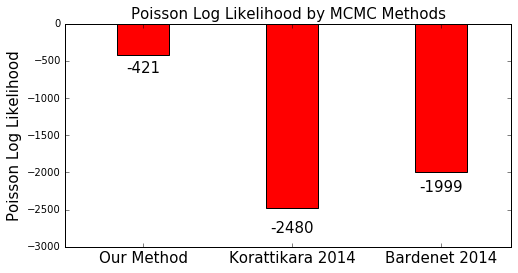

In [50]:
# plot the divergence (poisson likelihood) value as bar plot
N = 3
values = (kl1, kl3, kl4)

ind = np.arange(N) # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots(figsize=(8,4))
rects1 = ax.bar(ind+width, values, width, color='r')

# add some text for labels, title and axes ticks
ax.set_ylabel('Poisson Log Likelihood', size=15)
ax.set_title('Poisson Log Likelihood by MCMC Methods', size=15)
ax.set_xticks(ind + width*1.5)
ax.set_xticklabels(('Our Method', 'Korattikara 2014', 'Bardenet 2014'), size=15)
ax.set_ylim([-3000,0])

def autolabel(rects):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., -1.150*max(height,600),
                '%d' % int(-1*height),
                ha='center', va='bottom', size=15)

autolabel(rects1)

plt.show()